# Consulting Game – Data Analysis Pipeline

### Overview
This notebook was created as part of the **AI Architecture / Consulting Game** project,  
where the goal is to analyze and optimize the fictional retail store **“Sill og Snus”** (under *Smutsiga Megastore*).  
We were provided with multiple JSON datasets (`_0` → `_3`) representing different simulation rounds or scenarios,  
each containing product inventories, prices, worker schedules, supplier prices, and sales transactions.

Our task is to:
- Understand the store’s performance and data structure.
- Combine all information into a single analytical dataset.
- Compute key business metrics (sales, profit, margins, etc.).
- Visualize trends and identify potential improvements.
- Prepare the data for further modeling or strategic recommendations.

---

### Structure
- **Section 1:** Setup and environment configuration  
- **Section 2:** Load, normalize and merge JSON data across all versions  
- **Section 3:** Visualizations and statistical analysis of sales and profitability  

---

### Role of ChatGPT (GPT-5)
GPT was used to:
- Design and implement the data processing pipeline for JSON and multi-version datasets.  
- Create robust parsing logic for complex transaction structures (`merch_types` + `merch_amounts`).  
- Develop clear documentation and visualization code.  
- Generate readable, maintainable Python code with comments and analysis support.  
- Assist in interpreting business meaning (e.g., linking product performance to pricing).  

All code and explanations in this notebook were collaboratively produced and verified  
to ensure clarity, reusability, and consistency across the full dataset (`_0–_3`).  

---

**Author(s):** Mohamaco Solutions LTD / Cornelius Brandt, Maximilian Eckstein, Mohammad Itani  
**Assisted by:** ChatGPT (GPT-5)  
**Course:** AI Architecture / Consulting Game  
**Client:** Smutsiga Megastore – *Sill og Snus*  
**Date:** 12th October 2025

In [16]:
# === Consulting Game: Notebook Setup =========================================
# Dependencies
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty pandas display
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# ---- Workspace config (generic for teammates) -------------------------------
# Project name (can be adapted individually)
WORKSPACE_NAME = "IKT110_ECKSTEIN"   # or leave empty if not needed
PROJECT_NAME = "consulting"

# Data version (_0 for baseline)
DATA_VERSION = 0

# Paths relative to notebook position (since notebook is inside /consulting)
ROOT = Path(".")
DATA_DIR = ROOT / "data"
OUT_DIR = ROOT / "output"

# Create output dir if missing
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Subfolders
AMOUNTS_DIR = DATA_DIR / "amounts"
PRICES_DIR = DATA_DIR / "prices"
SCHEDULES_DIR = DATA_DIR / "schedules"
TRANSACTIONS_DIR = DATA_DIR / "transactions"
WORKERS_DIR = DATA_DIR / "workers"

# Helper functions
def read_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def read_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8-sig") as f:
        for lineno, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            try:
                rows.append(json.loads(s))
            except Exception as e:
                raise ValueError(f"JSONL parse error at line {lineno}: {e}")
    if not rows:
        raise ValueError("File is empty or contains no valid JSON lines.")
    return pd.DataFrame(rows)

def to_json(obj, path: Path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

print("Setup OK")
print("Data dir :", DATA_DIR.resolve())
print("Output dir:", OUT_DIR.resolve())

Setup OK
Data dir : /home/maxge/studies/bachelor_mechatronics/semester_5/exchange_UiA/IKT110_artificial_intelligence_architecture/IKT110_eckstein/portfolio/consulting/data
Output dir: /home/maxge/studies/bachelor_mechatronics/semester_5/exchange_UiA/IKT110_artificial_intelligence_architecture/IKT110_eckstein/portfolio/consulting/output


## Section 2 — Data Loading, Normalization & Merging (All Versions)

In this section, we build the **core analytical dataset** from all provided JSON files (`_0` → `_3`).  
The goal is to combine product information, prices, inventory amounts, supplier costs, and actual sales transactions into one clean table.

### What happens here
1. **Load all core tables** for each version:
   - `amounts_{v}.json` → current stock quantities  
   - `prices_{v}.json` → selling prices  
   - `supplier_prices.json` → supplier costs per product  

2. **Normalize transactions**  
   Each `transactions_{v}.json` file contains nested lists with  
   `merch_types` (products sold) and `merch_amounts` (quantities).  
   We flatten these into a long DataFrame:


3. **Merge all data sources**
- Add the correct `price` and `supplier_price` for the same version.  
- Compute key metrics per transaction:
  - `revenue = qty * price`
  - `gross_profit = qty * (price - supplier_price)`

4. **Aggregate and join back**
- Aggregate per `(version, product)` → total `qty`, `revenue`, `gross_profit`.  
- Merge these totals back into the product snapshot table (`products`).

5. **Calculate snapshot-based metrics**
- `margin_per_unit`, `inventory_value`, `potential_revenue`, `potential_profit`.

6. **Output**
- Clean CSV exports for validation and plotting:  
  - `products_master_all_versions.csv`  
  - `sales_by_product_version.csv`  
  - `transactions_lines_all_versions.csv`  

The result is a consistent multi-version dataset ready for analysis and visualization in Section 3.

In [17]:
# === Section 2 — Load → Normalize → Merge (multi-version, robust) ============

# Config: which versions to load (_0.._3). Change to [0] to analyze baseline only.
VERSIONS = [0, 1, 2, 3]

# ---- Paths (based on your notebook living in /consulting) -------------------
DATA_DIR = Path("./data")
AMOUNTS_DIR = DATA_DIR / "amounts"
PRICES_DIR = DATA_DIR / "prices"
SCHEDULES_DIR = DATA_DIR / "schedules"
TRANSACTIONS_DIR = DATA_DIR / "transactions"
WORKERS_DIR = DATA_DIR / "workers"
OUT_DIR = Path("./output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def read_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def read_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8-sig") as f:
        for lineno, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            try:
                rows.append(json.loads(s))
            except Exception as e:
                raise ValueError(f"JSONL parse error at line {lineno}: {e}")
    if not rows:
        raise ValueError("File is empty or contains no valid JSON lines.")
    return pd.DataFrame(rows)

# ---- Core tables loader per version -----------------------------------------
def load_core_tables(version: int):
    amounts_dict  = read_json(AMOUNTS_DIR / f"amounts_{version}.json")       # {product: amount}
    prices_dict   = read_json(PRICES_DIR / f"prices_{version}.json")         # {product: price}
    supplier_dict = read_json(DATA_DIR / "supplier_prices.json")             # {product: supplier_price}

    amounts  = pd.DataFrame(list(amounts_dict.items()),  columns=["product", "amount"]).set_index("product")
    prices   = pd.DataFrame(list(prices_dict.items()),   columns=["product", "price"]).set_index("product")
    supplier = pd.DataFrame(list(supplier_dict.items()), columns=["product","supplier_price"]).set_index("product")

    products = (
        amounts.join(prices, how="outer")
               .join(supplier, how="left")
               .fillna({"amount": 0, "price": 0, "supplier_price": np.nan})
               .reset_index()
               .rename(columns={"index":"product"})
    )
    products["version"] = version
    # Derived snapshot metrics
    products["margin_per_unit"]  = products["price"] - products["supplier_price"]
    products["inventory_value"]  = products["amount"] * products["price"]
    products["potential_profit"] = products["amount"] * products["margin_per_unit"]
    products["potential_revenue"] = products["amount"] * products["price"]
    return products

# ---- Transactions normalizer (correct for your schema) ----------------------
def normalize_transactions_fixed(transactions_raw: dict, version: int) -> pd.DataFrame:
    """
    Expected shape:
    {
      "1": [
        {
          "customer_id": "...",
          "merch_types":   ["hammer", "nails", ...],
          "merch_amounts": [2,         3,       ...],
          "register_worker": "w_...",
          "transaction_type": "customer_sale"
        },
        ...
      ]
    }
    """
    rows = []
    for _, tx_list in transactions_raw.items():
        if not isinstance(tx_list, list):
            continue
        for tx in tx_list:
            types   = tx.get("merch_types", []) or []
            amounts = tx.get("merch_amounts", []) or []
            if not types or not amounts:
                continue
            # parallel lists
            for t, a in zip(types, amounts):
                try:
                    qty = float(a)
                except Exception:
                    qty = np.nan
                rows.append({
                    "product": str(t),
                    "qty": qty,
                    "worker": tx.get("register_worker"),
                    "customer_id": tx.get("customer_id"),
                    "tx_type": tx.get("transaction_type"),
                    "version": version,
                })
    return pd.DataFrame(rows)

# ---- Load all versions ------------------------------------------------------
all_products = []
all_tx = []

for v in VERSIONS:
    # products per version
    prod_v = load_core_tables(v)
    all_products.append(prod_v)

    # transactions per version (if present)
    tx_path = TRANSACTIONS_DIR / f"transactions_{v}.json"
    if tx_path.exists():
        raw = read_json(tx_path)
        tx_v = normalize_transactions_fixed(raw, v)
        all_tx.append(tx_v)

# Concatenate
products = pd.concat(all_products, ignore_index=True)
transactions = pd.concat(all_tx, ignore_index=True) if all_tx else pd.DataFrame(columns=["product","qty","version"])

# ---- Merge price per (product, version) & compute realized metrics ----------
if not transactions.empty:
    price_cols = products[["product","version","price","supplier_price"]].copy()
    transactions = transactions.merge(price_cols, on=["product","version"], how="left")

    # Realized revenue and gross profit from sold qty at version's price
    transactions["revenue"] = transactions["qty"].astype(float) * transactions["price"].astype(float)
    transactions["gross_profit"] = transactions["qty"].astype(float) * (transactions["price"] - transactions["supplier_price"])

    # Aggregates by (version, product)
    sales_by_product_version = (
        transactions.groupby(["version","product"], dropna=False)[["qty","revenue","gross_profit"]]
        .sum()
        .reset_index()
        .sort_values(["version","revenue"], ascending=[True, False])
    )
else:
    sales_by_product_version = pd.DataFrame(columns=["version","product","qty","revenue","gross_profit"])
    print("No transactions parsed — check files/paths.")

# ---- Merge aggregates back to products snapshot -----------------------------
products = products.merge(sales_by_product_version, on=["version","product"], how="left")\
                   .fillna({"qty":0.0, "revenue":0.0, "gross_profit":0.0})

# ---- Totals & diagnostics ---------------------------------------------------
def _nz(x): return float(np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0))

totals = products.groupby("version").agg(
    inventory_value=("inventory_value","sum"),
    potential_revenue=("potential_revenue","sum"),
    potential_profit=("potential_profit","sum"),
    revenue=("revenue","sum"),
    realized_gross_profit=("gross_profit","sum"),
).reset_index()

print("Per-version totals (snapshot vs realized):")
display(totals)

# ---- Save helpful CSVs ------------------------------------------------------
products.to_csv(OUT_DIR / "products_master_all_versions.csv", index=False)
sales_by_product_version.to_csv(OUT_DIR / "sales_by_product_version.csv", index=False)
transactions.to_csv(OUT_DIR / "transactions_lines_all_versions.csv", index=False)
print("Saved:")
print(" - products_master_all_versions.csv")
print(" - sales_by_product_version.csv")
print(" - transactions_lines_all_versions.csv")

# ---- Optional: workers & schedules (baseline) -------------------------------
try:
    workers_path   = WORKERS_DIR / "workers.jsonl"
    schedules_path = SCHEDULES_DIR / f"schedules_{VERSIONS[0]}.json"
    if workers_path.exists():
        workers = read_jsonl(workers_path)
        print("\nWorkers — head()")
        display(workers.head())
    if schedules_path.exists():
        schedules_raw = read_json(schedules_path)
        sched_rows = []
        for day, entries in schedules_raw.items():
            for e in entries:
                sched_rows.append({"day": day, **e, "version": VERSIONS[0]})
        schedule_df = pd.DataFrame(sched_rows)
        print("\nSchedule (baseline) — head()")
        display(schedule_df.head())
except Exception as e:
    print(f"\nStaffing section skipped: {e}")

Per-version totals (snapshot vs realized):


,version,inventory_value,potential_revenue,potential_profit,revenue,realized_gross_profit
0,0,"2,437,396.23","2,437,396.23","688,087.23","1,444,527.59","383,193.59"
1,1,"2,765,453.72","2,765,453.72","814,018.72","1,053,705.70","310,468.70"
2,2,"2,820,148.60","2,820,148.60","810,566.60","801,424.92","232,142.92"
3,3,"3,053,506.39","3,053,506.39","875,793.39","1,036,064.91","287,678.91"


Saved:
 - products_master_all_versions.csv
 - sales_by_product_version.csv
 - transactions_lines_all_versions.csv

Workers — head()


,name,worker_id,age,salary
0,Richard Kulik,w_f25ba256-ccbf-4234-9986-fc0fffe2c937,33,"7,002.17"
1,Nettie Harris,w_0f1b727e-b833-4be8-9199-5f00f1dde500,21,"6,750.25"
2,Crystal Clark,w_aa04f664-fb82-4343-be47-803507429374,47,"7,128.90"
3,Robert Rosen,w_76592d3d-b442-4e10-a4b2-3cfb18bbfc4f,53,"5,641.34"
4,Billy Overfield,w_bcdc0b1a-a066-4a8a-ab58-f6eafa27e5b3,47,"5,758.86"



Schedule (baseline) — head()


,day,worker_id,department,shift,version
0,monday,w_f25ba256-ccbf-4234-9986-fc0fffe2c937,registers,1,0
1,monday,w_0f1b727e-b833-4be8-9199-5f00f1dde500,registers,2,0
2,monday,w_aa04f664-fb82-4343-be47-803507429374,registers,1,0
3,monday,w_76592d3d-b442-4e10-a4b2-3cfb18bbfc4f,registers,2,0
4,monday,w_bcdc0b1a-a066-4a8a-ab58-f6eafa27e5b3,registers,1,0


## Section 3 — Visualization & Statistical Overview

This section provides a visual and numerical overview of the store performance across all dataset versions.

### What we do
1. **Select a focus version (`FOCUS_VERSION`)**  
   - Example: `0` = baseline, `1..3` = later scenarios or pricing rounds.

2. **Plot and summarize**
   - Top-selling products by `revenue`.
   - Most profitable products by `gross_profit`.
   - Comparison of *potential* vs *realized* revenue/profit.
   - Price-vs-Quantity scatter (correlation indicator for price sensitivity).
   - ABC classification by revenue contribution (A = top 80 %, B = next 15 %, C = bottom 5 %).

3. **Cross-version comparison**
   - Total revenue by version (overall performance trend).
   - Estimated “price → quantity” slope per version using a simple OLS regression.

### Why this matters
These plots and summaries let us:
- verify that the transaction parsing and price mapping are correct,
- detect product trends or shifts between versions,
- and prepare for model building (e.g., elasticity or optimization models).

At the end of this section, you’ll have a visual confirmation that the data pipeline works
and a first quantitative understanding of how each version performed.

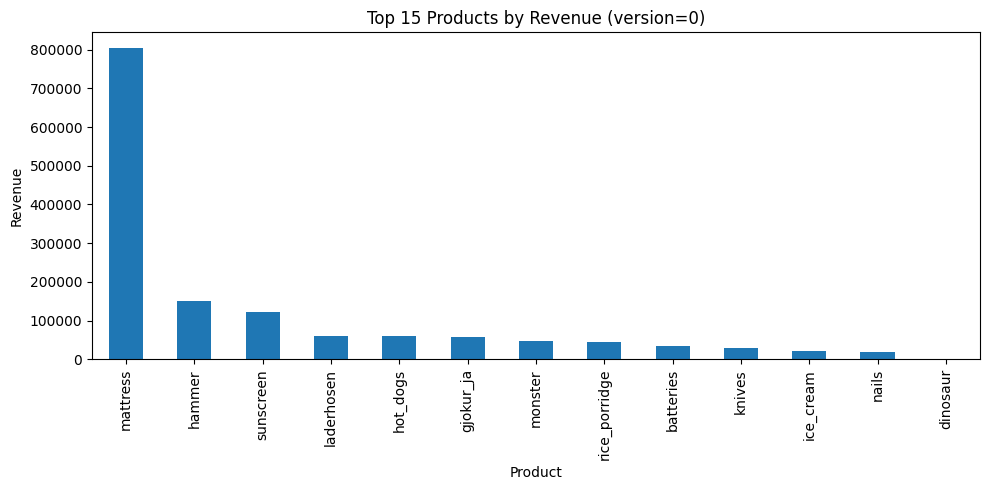

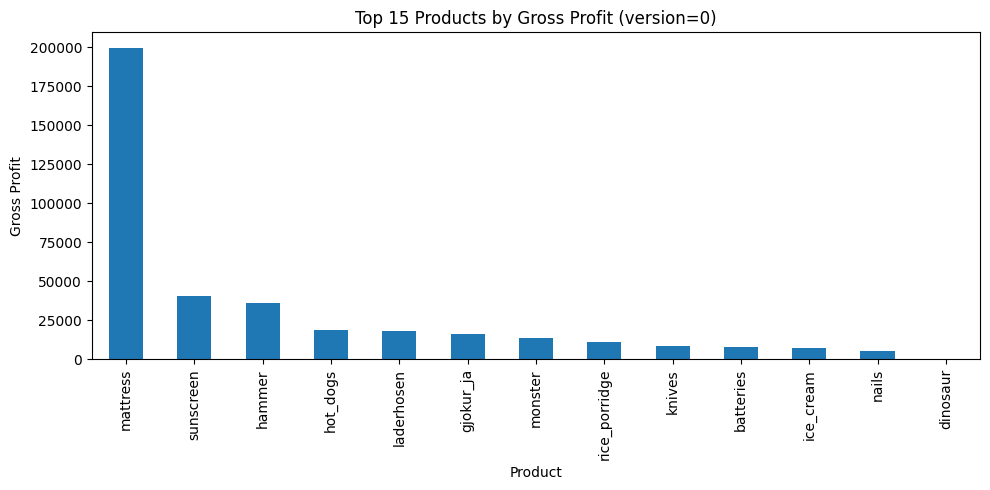

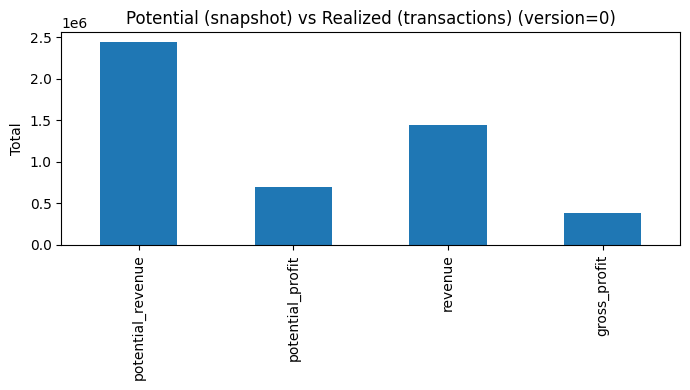

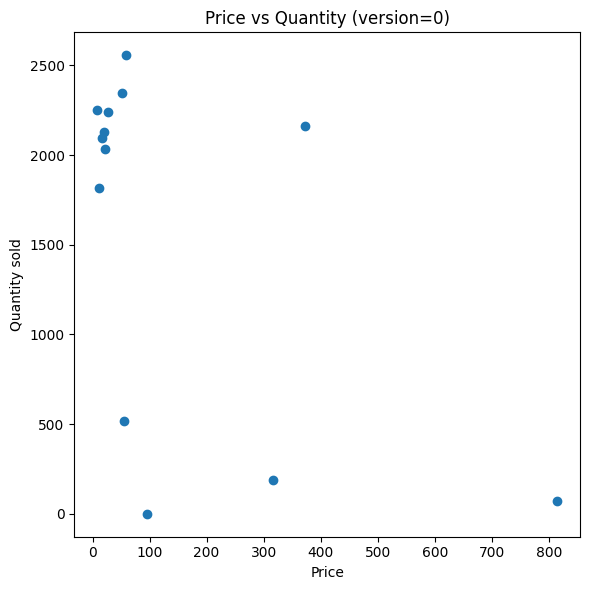

Correlation(price, qty) (version=0): -0.545

ABC summary (focus version):


ABC
C    5
A    4
B    4
Name: count, dtype: int64

Saved: output/products_ABC_v0.csv


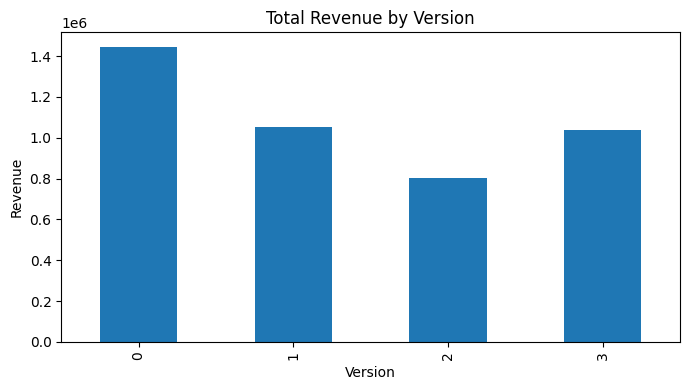

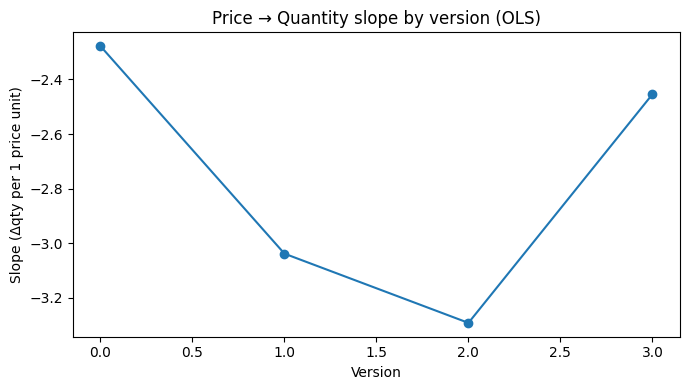

Saved: output/price_qty_slope_by_version.csv

Section 3 finished.


In [18]:
# === Section 3 — Visualizations & Light Stats (multi-version aware) ==========

HAS_VERSION = "version" in products.columns
FOCUS_VERSION = 0  # change to 1/2/3 to explore other rounds

def sel(df, v=None):
    if not HAS_VERSION or v is None:
        return df.copy()
    return df.loc[df["version"] == v].copy()

prod_focus = sel(products, FOCUS_VERSION)

# Safety: cast numerics
for col in ["amount","price","supplier_price","margin_per_unit","inventory_value",
            "potential_profit","potential_revenue","qty","revenue","gross_profit"]:
    if col in prod_focus.columns:
        prod_focus[col] = prod_focus[col].astype(float).replace([np.inf, -np.inf], np.nan).fillna(0.0)

title_tag = f"(version={FOCUS_VERSION})" if HAS_VERSION else "(baseline)"

# --- 1) Top-N by realized revenue -------------------------------------------
if "revenue" in prod_focus.columns and prod_focus["revenue"].sum() > 0:
    topN = 15
    plt.figure(figsize=(10,5))
    prod_focus.sort_values("revenue", ascending=False).head(topN)\
        .set_index("product")["revenue"].plot(kind="bar")
    plt.title(f"Top {topN} Products by Revenue {title_tag}")
    plt.ylabel("Revenue")
    plt.xlabel("Product")
    plt.tight_layout()
    plt.show()
else:
    print("No revenue data for selected version.")

# --- 2) Top-N by realized gross profit --------------------------------------
if "gross_profit" in prod_focus.columns and prod_focus["gross_profit"].sum() > 0:
    topN = 15
    plt.figure(figsize=(10,5))
    prod_focus.sort_values("gross_profit", ascending=False).head(topN)\
        .set_index("product")["gross_profit"].plot(kind="bar")
    plt.title(f"Top {topN} Products by Gross Profit {title_tag}")
    plt.ylabel("Gross Profit")
    plt.xlabel("Product")
    plt.tight_layout()
    plt.show()

# --- 3) Potential vs realized (bar comparison of totals) ---------------------
totals_focus = prod_focus[["potential_revenue","potential_profit","revenue","gross_profit"]].sum()
plt.figure(figsize=(7,4))
totals_focus.plot(kind="bar")
plt.title(f"Potential (snapshot) vs Realized (transactions) {title_tag}")
plt.ylabel("Total")
plt.tight_layout()
plt.show()

# --- 4) Price vs Quantity (scatter) & correlation ----------------------------
if {"price","qty"}.issubset(prod_focus.columns) and prod_focus["qty"].sum() > 0:
    plt.figure(figsize=(6,6))
    plt.scatter(prod_focus["price"].fillna(0), prod_focus["qty"].fillna(0))
    plt.title(f"Price vs Quantity {title_tag}")
    plt.xlabel("Price")
    plt.ylabel("Quantity sold")
    plt.tight_layout()
    plt.show()

    corr = np.corrcoef(prod_focus["price"].to_numpy(), prod_focus["qty"].to_numpy())[0,1]
    print(f"Correlation(price, qty) {title_tag}: {corr:.3f}")

# --- 5) ABC by realized revenue ---------------------------------------------
if "revenue" in prod_focus.columns:
    df_abc = prod_focus.sort_values("revenue", ascending=False).copy()
    total_rev = max(1e-9, df_abc["revenue"].sum())
    df_abc["cum_rev_share"] = df_abc["revenue"].cumsum() / total_rev
    df_abc["ABC"] = np.select(
        [df_abc["cum_rev_share"] <= 0.80,
         df_abc["cum_rev_share"].between(0.80, 0.95, inclusive="right"),
         df_abc["cum_rev_share"] > 0.95],
        ["A","B","C"],
        default="C"
    )
    print("\nABC summary (focus version):")
    display(df_abc["ABC"].value_counts())
    df_abc.to_csv(OUT_DIR / f"products_ABC_v{FOCUS_VERSION if HAS_VERSION else 0}.csv", index=False)
    print("Saved:", OUT_DIR / f"products_ABC_v{FOCUS_VERSION if HAS_VERSION else 0}.csv")

# --- 6) Multi-version comparisons -------------------------------------------
if HAS_VERSION and 'transactions' in globals() and not transactions.empty:
    # Total revenue by version
    rev_by_v = transactions.groupby("version")["revenue"].sum().sort_index()
    if rev_by_v.sum() > 0:
        plt.figure(figsize=(7,4))
        rev_by_v.plot(kind="bar")
        plt.title("Total Revenue by Version")
        plt.ylabel("Revenue")
        plt.xlabel("Version")
        plt.tight_layout()
        plt.show()

    # Quick OLS slope of price→qty per version (simple demand signal)
    from numpy.linalg import lstsq
    rows = []
    for v, dfv in products.groupby("version"):
        xv = dfv["price"].astype(float).to_numpy().reshape(-1,1)
        yv = dfv["qty"].astype(float).to_numpy()
        if len(dfv) >= 2 and np.any(yv > 0):
            X = np.c_[xv, np.ones_like(xv)]
            beta, *_ = lstsq(X, yv, rcond=None)  # y ≈ beta0*price + beta1
            rows.append({"version": v, "slope_price_to_qty": float(beta[0])})
    if rows:
        df_slope = pd.DataFrame(rows).sort_values("version")
        plt.figure(figsize=(7,4))
        plt.plot(df_slope["version"], df_slope["slope_price_to_qty"], marker="o")
        plt.title("Price → Quantity slope by version (OLS)")
        plt.xlabel("Version")
        plt.ylabel("Slope (Δqty per 1 price unit)")
        plt.tight_layout()
        plt.show()
        df_slope.to_csv(OUT_DIR / "price_qty_slope_by_version.csv", index=False)
        print("Saved:", OUT_DIR / "price_qty_slope_by_version.csv")

print("\nSection 3 finished.")

In [23]:
# === Quick sanity check: "mattress" sales in version 0 =========================

# You can play around with the dataframe here:

def check_product(product, version):
    df = transactions[
        (transactions["version"] == version) &
        (transactions["product"].str.lower() == product.lower())
    ]
    print(f"{product.title()} - v{version}: qty={df['qty'].sum():.0f}, revenue={df['revenue'].sum():,.2f}")


if "transactions" in globals() and not transactions.empty:
    mattress_v0 = transactions[
        (transactions["version"] == 0) &
        (transactions["product"].str.lower() == "mattress")
    ]

    total_qty = mattress_v0["qty"].sum()
    total_rev = mattress_v0["revenue"].sum() if "revenue" in mattress_v0 else 0.0

    print(f"Mattress sales (version 0):")
    print(f" - Number of transaction lines: {len(mattress_v0)}")
    print(f" - Total quantity sold: {total_qty:.0f}")
    print(f" - Total revenue: {total_rev:,.2f}")

    display(mattress_v0.head(5))  # show a few example rows
else:
    print("'transactions' DataFrame not found or empty.")

Mattress sales (version 0):
 - Number of transaction lines: 1349
 - Total quantity sold: 2161
 - Total revenue: 804,626.74


,product,qty,worker,customer_id,tx_type,version,price,supplier_price,revenue,gross_profit
10,mattress,1.00,w_7a032bac-6434-4970-9190-72545c58bd13,c_5902341a-6fbb-49e4-a6a9-dba311c5da30,customer_sale,0,372.34,280.00,372.34,92.34
11,mattress,1.00,w_aad7a61c-5db6-4558-ab8b-8f9eadbd7ad2,c_30b09263-6eab-4d87-b1ac-194610943032,customer_sale,0,372.34,280.00,372.34,92.34
13,mattress,1.00,w_f25ba256-ccbf-4234-9986-fc0fffe2c937,c_2a61ab81-92a4-43a5-9484-d6ede2d3e48c,customer_sale,0,372.34,280.00,372.34,92.34
16,mattress,1.00,w_bcdc0b1a-a066-4a8a-ab58-f6eafa27e5b3,c_138a3c48-0747-4f02-91a3-328a325e4685,customer_sale,0,372.34,280.00,372.34,92.34
40,mattress,1.00,w_46b19eef-7e0d-4052-9a60-d08320960024,c_3c7190d4-0694-4787-a188-30d836a7d7ca,customer_sale,0,372.34,280.00,372.34,92.34


## Next Steps – Upcoming Tasks

### Objective
Understand how changes in **prices**, **amounts (inventory)**, and **schedules (staffing)** affect **sales and transactions** across the four dataset versions.

---

### Tasks Overview

#### 1. Data Understanding & Verification
- Review the merged `products` DataFrame:
  - Check if `price`, `amount`, `qty`, and `revenue` values look realistic.
  - Confirm that transactions are correctly linked (e.g., "hammer" in version 0 → correct quantity).
  - Compare `potential_profit` vs `gross_profit` to validate logic.
- Inspect random samples from the dataset to ensure no duplicates or missing mappings.
- Create quick product checks:
  - Example: total quantity of "hammer" in version 0.
  - Example: top 5 products by revenue in version 1.

#### 2. Quantitative Analysis
- Summarize overall metrics:
  - total `revenue`, `gross_profit`, and `inventory_value` per version.
  - price ranges and average sales quantities.
- Identify trends between versions:
  - Which products increased or decreased in sales?
  - How did pricing or staffing changes correspond to these results?

#### 3. Modeling Preparation (Concept)
- Prepare a simplified feature table combining:
  - `price`, `amount`, and staffing intensity (from schedules).
  - outcome variables such as `qty`, `revenue`, and `gross_profit`.
- Analyze correlations and basic relationships (without external libraries if restricted).
- Explore simple numeric sensitivity tests (manual calculations or numpy-based linear models).

#### 4. Business Recommendations
- Based on observed trends, propose:
  - New **prices** that could improve profit or sales balance.
  - Adjusted **amounts (order quantities)** to reduce over- or under-stocking.
  - Possible **schedule** refinements if staffing correlates with higher sales.

#### 5. Final Deliverables (by Tuesday)
- Updated JSON files to send back:
  - `prices_4.json`  
  - `amounts_4.json`  
  - `schedules_4.json`
- Short summary of reasoning and visual evidence (charts + brief explanation).

---

**Goal:**  
Have a verified, interpretable dataset and clear evidence of how your decisions (price, stock, staff) drive store performance — ready to generate the improved company configuration.